In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import thư viện

In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#### Cố định giá trị ngẫu nhiên

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

#### Đọc dữ liệu

In [3]:
root_dir = '/content/drive/MyDrive/AIO2024/M06/W02/Data/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(root_dir)))
}

In [4]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

#### Chia bộ dữ liệu train, val, test

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

#### Class pytorch datasets

In [6]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

#### Xây dựng hàm tiền xử lý ảnh

In [7]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

#### Khai báo datasets object cho 3 bộ train, val, test

In [8]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)

val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)

test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

#### Khai báo dataloader

In [9]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

#### Xây dựng model

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1) -> None:
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 2)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)
        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [12]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [13]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,928
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]           4,160
      BatchNorm2d-11           [-1, 64, 28, 28]             128
    ResidualBlock-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 64, 14, 14]          36,928
      BatchNorm2d-14           [-1, 64,

#### Xây dựng hàm đánh giá model

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) /  len(losses)
    acc = correct / total
    return loss, acc

#### Xây dựng hàm huấn luyện model

In [15]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

#### Khai báo hàm loss và thuật toán tối ưu hóa:

In [16]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

#### Thực hiện huấn luyện

In [17]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

# save weights model
torch.save(model.state_dict(), 'weather_classification_weights.pt')

EPOCH 1:	Train loss: 1.5648	Val loss: 2.4091
EPOCH 2:	Train loss: 0.9061	Val loss: 2.3702
EPOCH 3:	Train loss: 0.6660	Val loss: 2.1154
EPOCH 4:	Train loss: 0.4279	Val loss: 1.7311
EPOCH 5:	Train loss: 0.2825	Val loss: 1.2117
EPOCH 6:	Train loss: 0.1704	Val loss: 1.1172
EPOCH 7:	Train loss: 0.1340	Val loss: 1.1413
EPOCH 8:	Train loss: 0.0827	Val loss: 1.4469
EPOCH 9:	Train loss: 0.0919	Val loss: 1.1836
EPOCH 10:	Train loss: 0.0427	Val loss: 1.2793
EPOCH 11:	Train loss: 0.0334	Val loss: 1.2358
EPOCH 12:	Train loss: 0.0255	Val loss: 1.2507
EPOCH 13:	Train loss: 0.0303	Val loss: 1.2380
EPOCH 14:	Train loss: 0.0191	Val loss: 1.3819
EPOCH 15:	Train loss: 0.0251	Val loss: 1.2859
EPOCH 16:	Train loss: 0.0193	Val loss: 1.3740
EPOCH 17:	Train loss: 0.0139	Val loss: 1.3207
EPOCH 18:	Train loss: 0.0112	Val loss: 1.3252
EPOCH 19:	Train loss: 0.0110	Val loss: 1.2939
EPOCH 20:	Train loss: 0.0080	Val loss: 1.3249
EPOCH 21:	Train loss: 0.0072	Val loss: 1.4265
EPOCH 22:	Train loss: 0.0068	Val loss: 1.32

Text(0, 0.5, 'Loss')

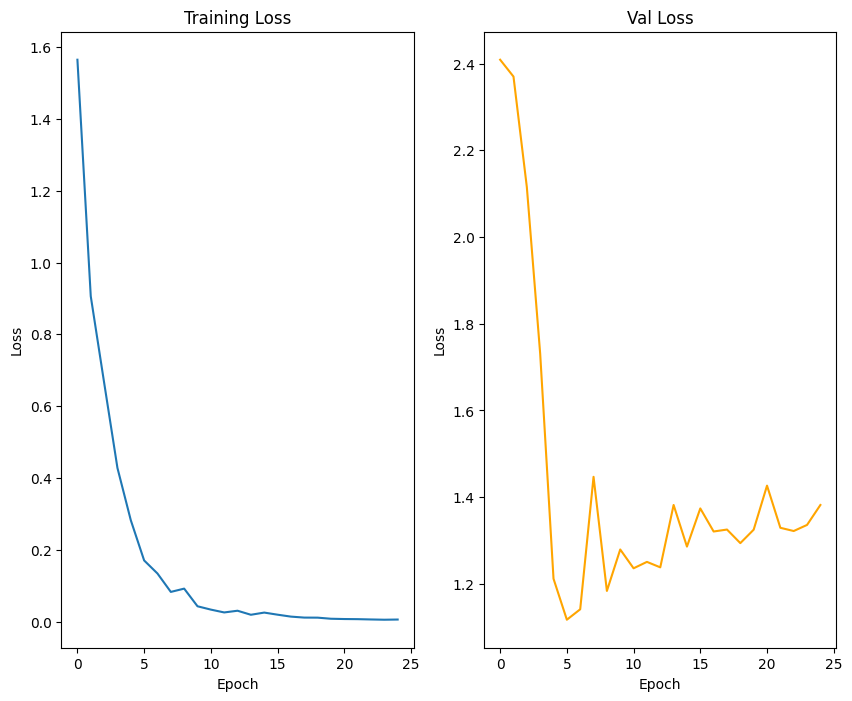

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

#### Đánh giá mô hình

In [19]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluate on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluate on val/test dataset
Val accuracy:  0.6742147552958364
Test accuracy:  0.710948905109489
